In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import torch
import torch.nn.functional as F
import datetime as dt
from datetime import datetime
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import sys 
from scipy.stats import randint
from numpy.polynomial.polynomial import polyfit

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
import keras.backend as K

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
password = "jinaf3279"

con = psycopg2.connect(dbname=dbname, user=sqluser, password = password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [220]:
##Get most dataset patient
def getSubject(table):
    query = """
    select subject_id, count(valuenum) from """+str(table)+"""
    group by subject_id
    order by count(valuenum) DESC
    """
    df = pd.read_sql_query(query,con)
    return df.head()

print(getSubject("chartevents"))

   subject_id   count
0       55639  758554
1       58242  669781
2       83629  598617
3       40548  441082
4       89223  403182


In [2]:
# def getLabItem(subject_id):
#     query = """
#     select le.itemid, d.label, count(le.itemid)
#     from labevents le
#     inner join D_LABITEMS d
#     on d.itemid = le.itemid
#     where subject_id = """+str(subject_id)+"""
#     and valuenum is not null
#     group by le.itemid, d.label
#     having count(le.itemid) >1000
#     order by count(le.itemid) DESC
#     """
#     df = pd.read_sql_query(query,con)
#     return df
# # print(getLabItem('13033'))

print('Measurements for subject_id = 89223')
def getChartItem(subject_id):
    query = """
    select ce.itemid, d.label, count(ce.itemid) 
    from chartevents ce 
    inner join d_items d 
    on d.itemid = ce.itemid 
    where subject_id =  """+str(subject_id)+"""
    group by ce.itemid, d.label 
    having count(ce.itemid) > 1000 
    order by count(ce.itemid) DESC
    """
    df = pd.read_sql_query(query,con)
    return df
# print('subject_id: 55639')
print(getChartItem('89223'))
# print(getChartItem('\nsubject_id: 58242'))

Measurements for subject_id = 89223
    itemid                              label  count
0   220045                         Heart Rate  18209
1   220210                   Respiratory Rate  18081
2   223835               Inspired O2 Fraction  17814
3   224689     Respiratory Rate (spontaneous)  17809
4   220339                           PEEP set  17809
5   223873                           Paw High  17809
6   223874                           Vti High  17809
7   223876                     Apnea Interval  17809
8   224697               Mean Airway Pressure  17809
9   224695                Peak Insp. Pressure  17809
10  224690           Respiratory Rate (Total)  17809
11  220292          Minute Volume Alarm - Low  17809
12  220293         Minute Volume Alarm - High  17809
13  224685            Tidal Volume (observed)  17791
14  220277        O2 saturation pulseoxymetry  17315
15  224687                      Minute Volume  15873
16  220052       Arterial Blood Pressure mean  13673
17  220050

In [6]:
def getValue(subject_id, itemid, table):
    query = """
    select valuenum, charttime
    from """+str(table)+"""
    where subject_id = """+str(subject_id)+""" and itemid = """+str(itemid)+"""
    and valuenum is not null
    order by charttime
    """
    df = pd.read_sql_query(query,con)
    

    timeSeries = []
    fmt = '%Y-%m-%d %H:%M:%S'
    for d in data['charttime']:
        d = d.strftime("%Y-%m-%d %H:%M:%S")
        ds = datetime.strptime(d,fmt)
        timeSeries.append(ds)
    return df, timeSeries
# print(getValue('13033', '50971'))
# plt.hist(getValue('13033', '50971')['valuenum'])
df, timeSeries = getValue('55639', '220045', 'chartevents')
df['valuenum'].describe()

In [29]:
# df1, timeSeries1 = getValue('55639', '224697', 'chartevents') #Mean Airway Pressure
# df2, timeSeries2 = getValue('55639', '220045', 'chartevents') #HR


# sns.set(color_codes=True)

# sns.distplot(df2['valuenum'],
#              bins=15)



# plt.hist(df['valuenum'])
# sns.distplot(df['valuenum'],
#                   bins=10,
#                   kde=False,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1})

In [254]:
# df1, timeSeries1 = getValue('55639', '220210', 'chartevents')
# df2, timeSeries2 = getValue('55639', '224689', 'chartevents')
# # plt.scatter(df2['valuenum'][:37122],df1['valuenum'])

# sns.distplot(df2['valuenum'],
#              bins=12)

In [28]:
# sns.distplot(df2['valuenum'],
#              bins=20)

In [33]:
# def getValue(subject_id, itemid):
#     cur.execute("select valuenum, charttime "
#                 "from chartevents "
#                 "where subject_id = ANY(%s) AND itemid = ANY(%s)"
#                 "order by charttime;", ([subject_id],[itemid]))
    
#     rows = cur.fetchall()
#     fmt = '%Y-%m-%d'
#     value = []
#     timeSeries = []
#     for row in rows:
#         value.append(row[0])
#         timeSeries.append(row[1])
    
#     return value,timeSeries

# values1,timeSeries1 = getValue(55639,220045)
# values2,timeSeries2 = getValue(55639,220210)
# print(values1)
# from scipy import stats
# type(values1)
# stats.ttest_rel(values1,values2)
# plt.scatter(values1,values2)

# plt.plot(timeSeries1,normalize(values1))
# # plt.plot(timeSeries2,values2)
# plt.plot(timeSeries2,normalize(values2))
# plt.plot(timeSeries1,values1)


# def normalize(v): 

#     norm = np.linalg.norm(v) 

#     if norm == 0: 

#         return v 

#     return v / norm
# # normalize(values1)
# stats.ttest_ind(normalize(values1),normalize(values2))
# round(8.373827462205947e-08,100)

# sns.distplot(normalize(values2),
#              bins=15)

In [34]:
# from scipy import stats

# stats.ttest_ind(values1,values2)


# def getChartValue(subject_id, itemid, table):
#     query = """
#     select valuenum, charttime
#     from """+str(table)+"""
#     where subject_id = """+str(subject_id)+""" and itemid = """+str(itemid)+"""
#     and valuenum is not null
#     order by charttime
#     """
#     df = pd.read_sql_query(query,con)
    

#     timeSeries = []
#     fmt = '%Y-%m-%d %H:%M:%S'
#     for d in df['charttime']:
#         d = d.strftime("%Y-%m-%d %H:%M:%S")
#         ds = datetime.strptime(d,fmt)
#         timeSeries.append(ds)
#     return df, timeSeries

# df1, timeSeries1 = getChartValue('55639', '220051', 'chartevents')
# df2, timeSeries2 = getChartValue('55639', '220050', 'chartevents')

# stats.ttest_rel(normalize(df1['valuenum']),normalize(df2['valuenum']))



In [12]:
value1,timeSeries1 = getValue(55639,220045)
value2,timeSeries2 = getValue(55639,220210)
HR = []
RR = []
timeHR = []
timeRR = []

37493

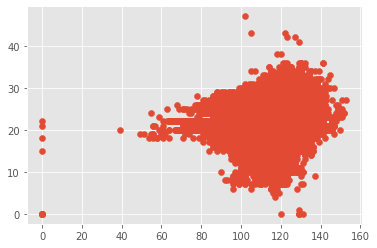

In [14]:
plt.scatter(HR,BP)
len(BP)

In [16]:
# from scipy.stats import pearsonr

# corr, _ = pearsonr(HR, BP)
# corr


type(ts[0])

datetime.datetime

In [5]:
def match(value1, value2, timeSeries1, timeSeries2):
    values1,values2,timeSeries = [],[],[]
    for m in range(len(value1)):
        for n in range(len(value2)):
            if timeSeries1[m] == timeSeries2[n]:
                timeSeries.append(timeSeries1[m])
                values1.append(value1[m])
                values2.append(value2[n])
    return values1, values2, timeSeries

hr, bpd, ts = match(HR, BPD, hrtime, bpdtime)
_, bps, _ = match(HR, BPS, hrtime, bpstime)

In [77]:
hr,rr,ts1 = match(BPD, RR, bpdtime, rrrime)

In [78]:
corr, _ = pearsonr(hr,rr)
corr

0.30282565373104386

In [65]:
hr, bpd, ts = match(hr,bpd, ts1,ts)

In [67]:
len(rr)

13516

In [4]:
def getValue(subject_id, itemid):
    cur.execute("select valuenum, value, charttime "
                "from chartevents "
                "where valuenum is not null and subject_id = ANY(%s) AND itemid = ANY(%s)"
                "order by charttime;", ([subject_id],[itemid]))
    
    rows = cur.fetchall()
    fmt = '%Y-%m-%d'
    value = []
    timeSeries = []
    for row in rows:
        value.append(row[0])
        timeSeries.append(row[2])
    
    return value,timeSeries
HR, hrtime = getValue(89223, 220045)
# RR, rrtime = getValue(55639, 220210)
# MAR, martime = getValue(55639, 224697)
# MV, mvtime = getValue(55639, 224687)
# INSP, intime = getValue(55639, 226873)
# EXSP, extime = getValue(55639, 226871)
BPS, bpstime = getValue(89223, 220050)
BPD, bpdtime = getValue(89223, 220051)
RR, rrrime = getValue(89223, 220210)
# IR, irtime = getValue(40548, 226873)
# CVP, cvptime = getValue(55639, 220074)





# plotByTime(55639, 224697,  'Mean Airway Pressure','r')
# plotByTime(55639, 224687, 'minute volume','b')

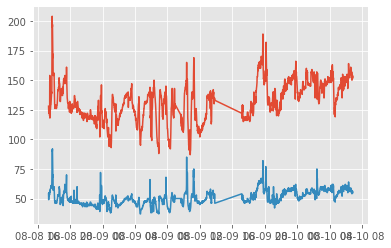

In [38]:
# plt.plot(hrtime,HR)
plt.plot(bpstime[:2000],BPS[:2000])
plt.plot(bpdtime[:2000],BPD[:2000])
# plt.plot(rrrime,RR)

In [105]:
# plt.scatter(ts[:2000], bps[:2000])
# plt.scatter(BPS,BPD)
# print(len(ER))
print(len(bps))
corr, _ = pearsonr(bpd,bps)
corr


13628


0.8592585292673599

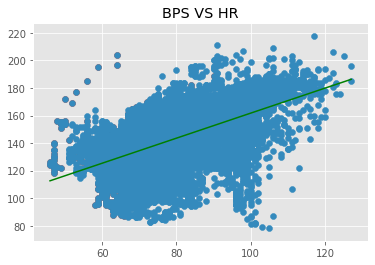

In [36]:
# print(bps[:10], bpd[:10])
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import operator


plt.scatter(hr[:2000], bps[:2000])
plt.title('BPS VS HR')
# corr, _ = pearsonr(hr,bps)
hr, bps = np.asarray(hr), np.asarray(bps)

# corr

b,m = polyfit(bpd, bps, 1)
# # fit2 = polyfit(hr, bps, 2)
# y1 = np.polyval(fit1, hr)

# plt.plot(hr, b + m * hr, 'red')
m,b
# plt.plot(hr, y1)



x = hr[:, np.newaxis]
y = bps[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='green')
plt.show()

In [3]:
"""
subject_id: 55639
    itemid                              label  count
0   220045                         Heart Rate  37569
1   220210                   Respiratory Rate  37499
2   224689     Respiratory Rate (spontaneous)  37123
3   223835               Inspired O2 Fraction  37123
4   223876                     Apnea Interval  37122
5   220293         Minute Volume Alarm - High  37122
6   220339                           PEEP set  37122
7   223873                           Paw High  37122
8   223874                           Vti High  37122
9   224690           Respiratory Rate (Total)  37122
10  224695                Peak Insp. Pressure  37122
11  224697               Mean Airway Pressure  37122
12  224685            Tidal Volume (observed)  37121
13  220292          Minute Volume Alarm - Low  36985
14  224687                      Minute Volume  36883
15  220277        O2 saturation pulseoxymetry  35914
16  224688             Respiratory Rate (Set)  19625
17  224738                   Inspiratory Time  19625
18  226873                  Inspiratory Ratio  19624
19  226871                   Expiratory Ratio  19624
20  224686         Tidal Volume (spontaneous)  17638
21  224684                 Tidal Volume (set)  16517
22  220052       Arterial Blood Pressure mean  10478
23  220050   Arterial Blood Pressure systolic  10367
24  220051  Arterial Blood Pressure diastolic  10367
25  220074            Central Venous Pressure   9394
26  227187               Pinsp (Draeger only)   3108
"""

def plotByTime(subject_id, itemid, label, color):
    cur.execute("select valuenum, charttime "
                "from chartevents "
                "where subject_id = ANY(%s) AND itemid = ANY(%s)"
                "order by charttime;", ([subject_id],[itemid]))
    
    rows = cur.fetchall()
    value = []
    timeSeries = []
    fmt = '%Y-%m-%d %H:%M:%S' 
    for row in rows:
        try:
            timeSeries.append(row[1])
            value.append(row[0])
        except :
            pass

    ax = plt.gca()
    
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%y-%m-%d\n%a'))
    # ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=.2))
    plt.plot(timeSeries, value, color, label = label)

# plotByTime(58242, 220050,  'Mean Airway Pressure','r')
# plotByTime(58242, 220051, 'minute volume','b')

[176.0, 195.0, 169.0, 175.0, 174.0, 171.0, 155.0, 153.0, 159.0, 158.0] [98.0, 110.0, 89.0, 92.0, 91.0, 96.0, 89.0, 92.0, 85.0, 85.0]


0.3003187790981548

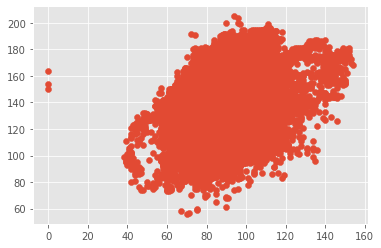

In [39]:
# bps, bpd = match(HR, BPS, hrtime, bpstime)
print(bps[:10], bpd[:10])

plt.scatter(hr, bpd)

corr, _ = pearsonr(hr,bpd)
corr

In [4]:
# class Net(torch.nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output):
#         super(Net, self).__init__()
#         self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
#         self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

#     def forward(self, x):
#         x = torch.tanh(self.hidden(x))      # activation function for hidden layer
#         x = self.predict(x)             # linear output
#         return x
# net = Net(n_feature=1, n_hidden=20, n_output=1)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
# loss_func = torch.nn.MSELoss()

In [174]:
con = psycopg2.connect(dbname=dbname, user=sqluser, password = password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))
def getChartValue(subject_id, itemid, table):
    query = """
    select valuenum, charttime
    from """+str(table)+"""
    where subject_id = """+str(subject_id)+""" and itemid = """+str(itemid)+"""
    and valuenum is not null
    order by charttime
    """
    df = pd.read_sql_query(query,con)
    df['charttime'] = pd.to_datetime(df.charttime) 
    
    timeSeries = []
    fmt = '%Y-%m-%d %H:%M:%S'
    for d in df['charttime']:
        d = d.strftime("%Y-%m-%d %H:%M:%S")
        ds = datetime.strptime(d,fmt)
        timeSeries.append(ds)
    return df, timeSeries

df, time = getChartValue('55639','220050','chartevents')
time[0]
con.close()
df = df.set_index(['charttime'])

In [173]:
con = psycopg2.connect(dbname=dbname, user=sqluser, password = password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))
# type(df['charttime'][0])
# # df = pd.DataFrame(index = df['charttime'])
# # df.se
# 
# # df.set_index(['Date','ProductID','SubProductId']).unstack(['ProductID','SubProductId'])
# bps = df.resample('d').mean().values
# df.plot

df1, time1 = getChartValue('55639','220051','chartevents')
con.close()
df1 = df1.set_index(['charttime'])


In [15]:
df1.plot

NameError: name 'df1' is not defined

In [2]:
value1 = df.valuenum.resample('2T').mean().values# len(bps)
value2 = df1.valuenum.resample('2T').mean().values# len(bps)
plt.scatter(value1,value2)
# corr, _ = pearsonr(value1,value2)
# corr
value1.tolist()

NameError: name 'df' is not defined

In [50]:
def getValue(subject_id, itemid):
    cur.execute("select valuenum, value, charttime "
                "from chartevents "
                "where valuenum is not null and subject_id = ANY(%s) AND itemid = ANY(%s)"
                "order by charttime;", ([subject_id],[itemid]))
    
    rows = cur.fetchall()
    fmt = '%Y-%m-%d'
    value = []
    timeSeries = []
    for row in rows:
        value.append(row[0])
        timeSeries.append(row[2])
    
    return value,timeSeries
values,timeSeries = getValue(89223, 220051)
with open('out.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % value for value in ts)

0.5423692318593297

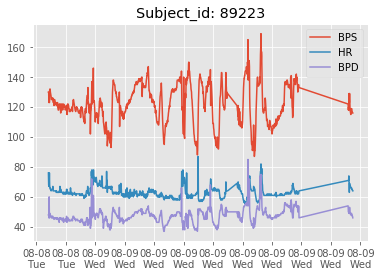

In [23]:
df = pd.read_csv('89223.csv', 
                 infer_datetime_format=True, 
                 low_memory=False, index_col='ts')
df.head()

# df.index = pd.to_datetime(df.index)
t = np.linspace(1,25911,25911)
# plt.rcParams["figure.figsize"] = [40,6]
plt.plot(ts[200:1200], df['bps'][200:1200], label = 'BPS')
plt.plot(ts[200:1200], df['hr'][200:1200], label = 'HR')
plt.plot(ts[200:1200], df['bpd'][200:1200], label = 'BPD')
plt.legend(loc='upper right')
plt.title('Subject_id: 89223')
ax = plt.gca()
plt.rcParams["figure.figsize"] = [11,6]
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%d\n%a'))
corr, _ = pearsonr(df['bps'],df['hr'])
corr

# df.index[1]

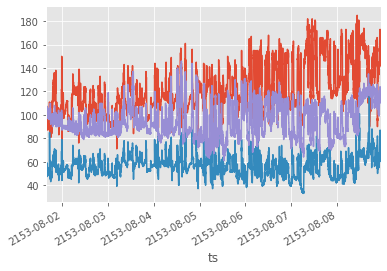

In [49]:
df['bps'].plot()
df['bpd'].plot()
df['hr'].plot()

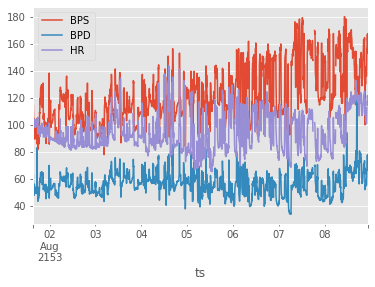

In [60]:
df['bps'].resample('250s').mean().plot(label = 'BPS')
df['bpd'].resample('250s').mean().plot(label = 'BPD')
df['hr'].resample('250s').mean().plot(label = 'HR')
plt.legend(loc='upper left')

In [128]:
# corr, _ = pearsonr(df['bps'].resample('250s').mean(),df['bpd'].resample('250s').mean())
# corr
bps=[]
bpd=[]
for s in df['bpd'].resample('3s').mean():
    if np.isinf(s) ==False and np.isnan(s) == False:
        bps.append(round(s,2))
for d in df['hr'].resample('3s').mean():
    if np.isinf(d) ==False and np.isnan(d) == False:
        bpd.append(round(d,2))
print(len(bps))
corr, _ = pearsonr(bps,bpd)
corr


10328


0.6534236803812937

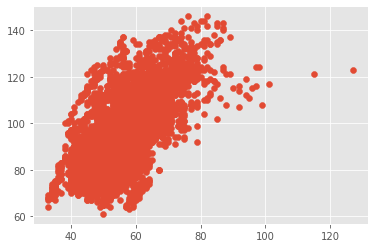

In [130]:
plt.scatter(bps,bpd)


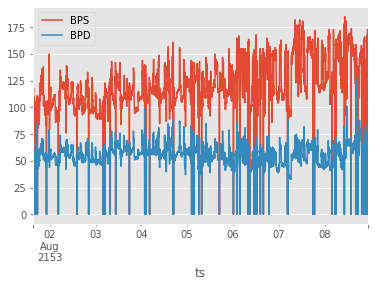

In [122]:
df['bps'].resample('60s').sum().plot(label = 'BPS')
df['bpd'].resample('60s').sum().plot(label = 'BPD')
df['hr'].resample('60s').sum().plot(label = 'HR')
plt.legend(loc='upper left')

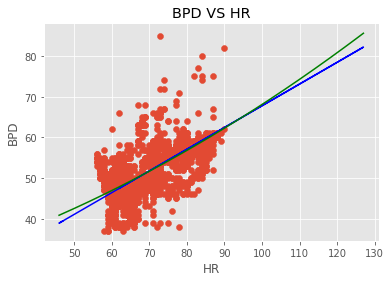

In [127]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import operator

#scatter
plt.scatter(df['hr'][200:2000],df['bpd'][200:2000])



#linear
b,m = polyfit(df['hr'], df['bpd'], 1)
plt.plot(df['hr'], b + m * df['hr'], 'blue')

#qudratic
x = df['hr'][:, np.newaxis]
y = df['bpd'][:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
# plt.scatter(x, y)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='green')

plt.title('BPD VS HR')
plt.xlabel('HR')
plt.ylabel('BPD')

plt.show()

In [87]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [128]:
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)

print(reframed)
# drop columns we  predict
# print(reframed.shape)
values = reframed.values
print(values.shape)
n_train_time = 20000
train = values[:n_train_time, :]
print(train.shape)
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
print(train_X.shape)
print(train_y.shape)
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

       var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1       0.012346   0.357143   0.240000  0.000000
2       0.000000   0.328571   0.173333  0.024691
3       0.024691   0.321429   0.253333  0.037037
4       0.037037   0.314286   0.213333  0.012346
5       0.012346   0.321429   0.226667  0.012346
...          ...        ...        ...       ...
13623   0.197531   0.371429   0.080000  0.209877
13624   0.209877   0.350000   0.080000  0.197531
13625   0.197531   0.350000   0.080000  0.197531
13626   0.197531   0.350000   0.080000  0.197531
13627   0.197531   0.357143   0.080000  0.197531

[13627 rows x 4 columns]
(13627, 4)
(13627, 4)
(13627, 3)
(13627,)
(13627, 1, 3) (13627,) (0, 1, 3) (0,)


(13627, 4)
(8760, 4)
(8760, 3)
(8760,)
(8760, 1, 3) (8760,) (4867, 1, 3) (4867,)
Train on 8760 samples, validate on 4867 samples
Epoch 1/20
 - 2s - loss: 0.0091 - mean_pred: 0.4162 - val_loss: 0.0050 - val_mean_pred: 0.3352
Epoch 2/20
 - 1s - loss: 0.0050 - mean_pred: 0.4382 - val_loss: 0.0040 - val_mean_pred: 0.3338
Epoch 3/20
 - 1s - loss: 0.0039 - mean_pred: 0.4387 - val_loss: 0.0031 - val_mean_pred: 0.3331
Epoch 4/20
 - 1s - loss: 0.0031 - mean_pred: 0.4391 - val_loss: 0.0024 - val_mean_pred: 0.3308
Epoch 5/20
 - 1s - loss: 0.0024 - mean_pred: 0.4392 - val_loss: 0.0018 - val_mean_pred: 0.3255
Epoch 6/20
 - 1s - loss: 0.0020 - mean_pred: 0.4391 - val_loss: 0.0014 - val_mean_pred: 0.3242
Epoch 7/20
 - 1s - loss: 0.0016 - mean_pred: 0.4391 - val_loss: 0.0012 - val_mean_pred: 0.3207
Epoch 8/20
 - 1s - loss: 0.0015 - mean_pred: 0.4389 - val_loss: 0.0011 - val_mean_pred: 0.3186
Epoch 9/20
 - 1s - loss: 0.0014 - mean_pred: 0.4388 - val_loss: 0.0010 - val_mean_pred: 0.3176
Epoch 10/20
 - 1

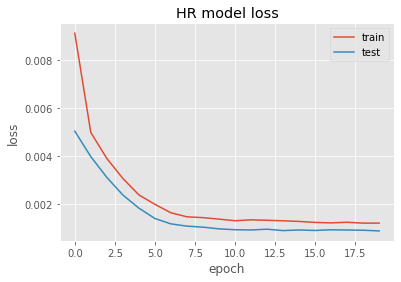

In [129]:
values = reframed.values
print(values.shape)
n_train_time = 365*24
train = values[:n_train_time, :]
print(train.shape)
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
print(train_X.shape)
print(train_y.shape)
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# train_X.shape
# train_X[1:3]




def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model = Sequential()
model.add(LSTM(
    units = 100, 
    input_shape=(train_X.shape[1], train_X.shape[2]),

))
# model.add(Activation('tanh'))

model.add(Dropout(.2))
model.add(Dense(1))

# adam = Adam(0.005)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_pred])


# validation_data=(test_X, test_y), 
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=40, verbose=2, shuffle=False, validation_data=(test_X, test_y))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('HR model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

In [130]:
# # make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
rr = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.2f' % rmse)
# print("no scaled: %.2f" %rr)


Test RMSE: 2.40


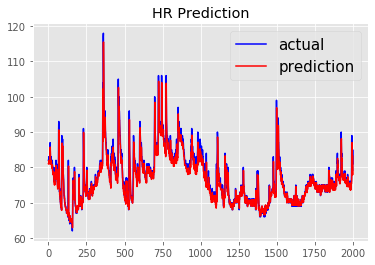

In [131]:
#dr .1 smr 2.886 2.876 2.881 2.888 2.897
            #2.876
aa=[x for x in range(2000)]

plt.plot(aa, inv_y[:2000], 'b', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")

plt.legend(fontsize=15, loc='upper right')
plt.title('HR Prediction')
plt.show()


In [170]:
values = reframed.values  #(10327, 4)

train = values[:n_train_time, :] #(8760,4)

test = values[n_train_time:, :] #(1567,4)

train_X, train_y = train[:, :-1], train[:, -1] #(8760, 3)

train_X.shape

x= [1,2,3,4,5]
x[3:]
# x[:3]

[4, 5]